In [1]:
%matplotlib inline

import math
import os
import struct
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from read_roi import read_roi_zip

import tifffile.tifffile

from scipy.ndimage  import interpolation
from skimage.transform import rotate

from scipy import stats
from scipy import misc

import csv

from scipy.optimize import curve_fit
from lmfit import Model
from lmfit import Parameter

C:\ProgramData\Anaconda3\lib\site-packages\tifffile\tifffile.py:306: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


In [2]:
################################################################################################################################
############# INPUT ############################################################################################################
################################################################################################################################

###########################
#### FILES ################
###########################

paths = ['path1/', 'path2/', 'path3/', 'path4/']

cometfiles = ['stack1.tif', 'stack2.tif', 'stack3.tif', 'stack4.tif']

roifiles = ['RoiSet1.zip', 'RoiSet2.zip', 'RoiSet3.zip', 'RoiSet4.zip']

###########################
#### ORGANIZATION #########
###########################

#Group data based on which are the same condition
replicates = [[0, 1], [2, 3]] #So here, the first two are one condition, the second two are another condition

conditions = ['Condition1', 'Condition2'] #Same order as list of lists in "groups"

savepath = 'savepath/'

###########################
#### VARIABLES ############
###########################

# Velocity filter data
lower_range = 4.7 #um/min
upper_range = 5.7

# Microscope-based settings
upix = 0.107 #pixel size
spf = 1 #seconds per frame

# Fitting variables
sigma = 130 #SD of the psf. sigma = FWHM/2.355.
km0 = 0.24 #Initial guess of maturation rate

###############################################################################################################

###########################
### ADVANCED VARIABLES ####
###########################

#Set to 1 to rescale image. This must be done on pseudo-flatfield corrected images. Leave at 0 otherwise.
#If on, you shouldn't compare absolute intensities, only normalized intensities.
rescale_flag = 0

#Set to 1 to normalize each individual comet before creating an average.
#Leave this at 0 if you're not sure.
normalize_flag = 0

###########################
#### CONSTANTS ############
###########################

#Amount by which to interpolate the image.
#This allows for subpixel localization of peak intensities.
subfactor = 6

#x-axis; in um; length of comet to analyze (centered around this value).
#Keep large (>4 um).
comet_length = 5

#y-axis; in um; width of comet images (centered around this value).
#Not important, center of comet width defines comet profile anyway.
comet_width = 0.6

#height of cropped region; in um. Width calculated from A to B distance
imheight = 1
#space to add on the x axis when cropping comets; in um
spacex = comet_length/2 + 0.55 

#Region to search relative to the location identified in a preceding frame (in um)
#(Comet should have moved forward from one frame to the next, so only search ahead.)
search_radius_x = 0.5
search_radius_y = 0.4

#Standard deviations to show in final profile, leave at 1! For troubleshooting only.
stds_final = 1

##########################
### CONVERSION FACTORS ###
##########################

#Multiply pixel values by this to get real distances.
#Divide distances by this to get pixel values.
to_um = upix/subfactor #microns
to_nm = to_um * 1000 #nanometers


imheight = int(imheight/upix) #crop is done before subfactor, no need for subfactor in this equation
spacex = int(spacex/upix)

comet_width = int(comet_width/to_um)
comet_length = int(comet_length/to_um)

searchrad_x = int(search_radius_x/to_um)
searchrad_y = int(search_radius_y/to_um)

In [3]:
################################################################################################################################
############# FUNCTIONS ########################################################################################################
################################################################################################################################

###############################################
##### ALIGN COMETS BY PEAK EB INTENSITY #######
###############################################

def process_comets(A, B, Z):
    
    #Initialize lists and arrays
    allcomets_stack = []
    aligned_comets_profs = []
    aligned_comet = np.zeros((comet_width, comet_length))
    peakpixels = []
    
    ###############################
    #### BASIC CALCULATIONS #######
    ###############################    

    #Total number of comets
    numcomets = Z[1] - Z[0] + 1
    
    #Length from start point to end point
    length = int(math.sqrt((B[0]-A[0])**2+(B[1]-A[1])**2))

    #The angle from start point to end point
    angle = math.atan2(B[1]-A[1], B[0]-A[0])

    #New start location
    new_x = int((A[0] - im_size/2)*math.cos(-angle) - (A[1] - im_size/2)*math.sin(-angle) + im_size/2)+1
    new_y = int((A[1] - im_size/2)*math.cos(-angle) + (A[0] - im_size/2)*math.sin(-angle) + im_size/2)+1
    
    #Incrementor
    cometnum = 0
    
    ###############################
    #### EXTRACT COMETS ###########
    ###############################

    for i in np.arange(Z[0]-1, Z[1], 1):

        #Rotate image
        im_rot = rotate(imstack[i], math.degrees(angle))

        #Crop out region with comet
        comet = im_rot[new_y-imheight-1:new_y+imheight, new_x-int(spacex):new_x+length+int(spacex)]

        #Interpolate by subfactor
        comet_sub = interpolation.zoom(comet, subfactor, order=3)

        ###########################################
        #### SUBCROP BASED ON PEAK ALIGNMENT ####
        ##########################################

        #################
        #DEFINE SEARCH AREA
        
        #Search extends backwards on the first comet
        if cometnum == 0:
            
            search_x = spacex*subfactor
            search_y = np.shape(comet_sub)[0] - imheight*subfactor
            search_area = comet_sub[search_y-searchrad_y:search_y+searchrad_y, search_x-searchrad_x:search_x+searchrad_x]
            
        #The search area shifts forwards in subsequent comets
        else:
            
            search_x = peakpix_x[0]
            search_y = peakpix_y[0]
            search_area = comet_sub[search_y-searchrad_y:search_y+searchrad_y, search_x-int(searchrad_x/2):search_x+searchrad_x*2]
        
        #################
        #FIND PEAK PIXEL
        
        peakpix_y, peakpix_x = np.where(comet_sub == np.amax(search_area))
        peakpixels.append((peakpix_x, peakpix_y))
        
        #################
        #EXTRACT COMET AROUND PEAK PIXEL (i.e. align)
        
        for x in np.arange(0, comet_length):

            for y in np.arange(0, comet_width):

                aroundpeak_x = peakpix_x - int(comet_length/2) + x
                aroundpeak_y = peakpix_y - int(comet_width/2) + y

                aligned_comet[y, x] = comet_sub[aroundpeak_y, aroundpeak_x]
        
        #################
        #Normalize if requested
        
        if normalize_flag == 1:
            
            aligned_comet = (aligned_comet - np.amin(aligned_comet))/(np.amax(aligned_comet) - np.amin(aligned_comet))
        
        #################
        #Store aligned comet in stack
        
        allcomets_stack.append(np.array(aligned_comet))
        
        ############# 
        cometnum += 1

    ###############################
    ######## Find velocity ########
    ###############################

    velocity = ((peakpixels[-1][0] - peakpixels[0][0]) * to_um) / (len(peakpixels)*spf / 60)

    ###############################
    ########### RETURN ############
    ###############################    

    return(allcomets_stack, peakpixels, velocity)


CONDITION: Bovine


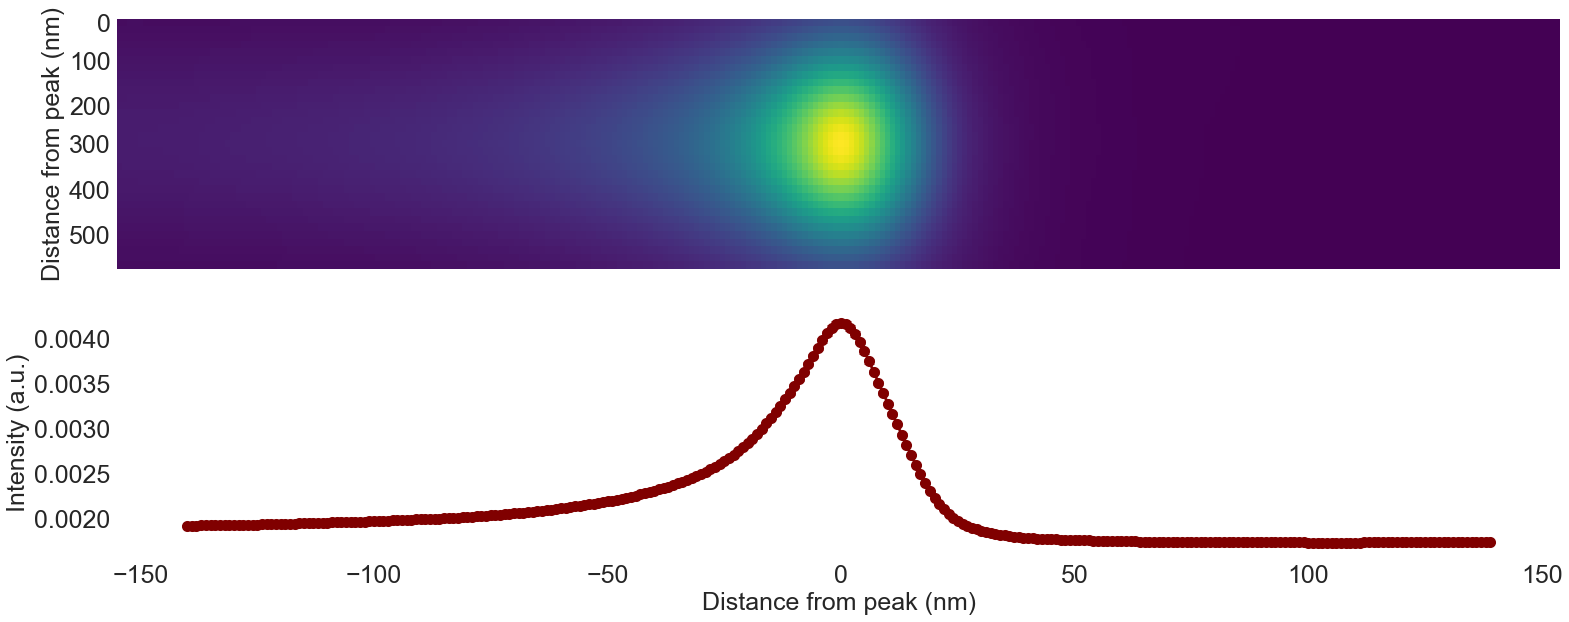

CONDITION: Worm


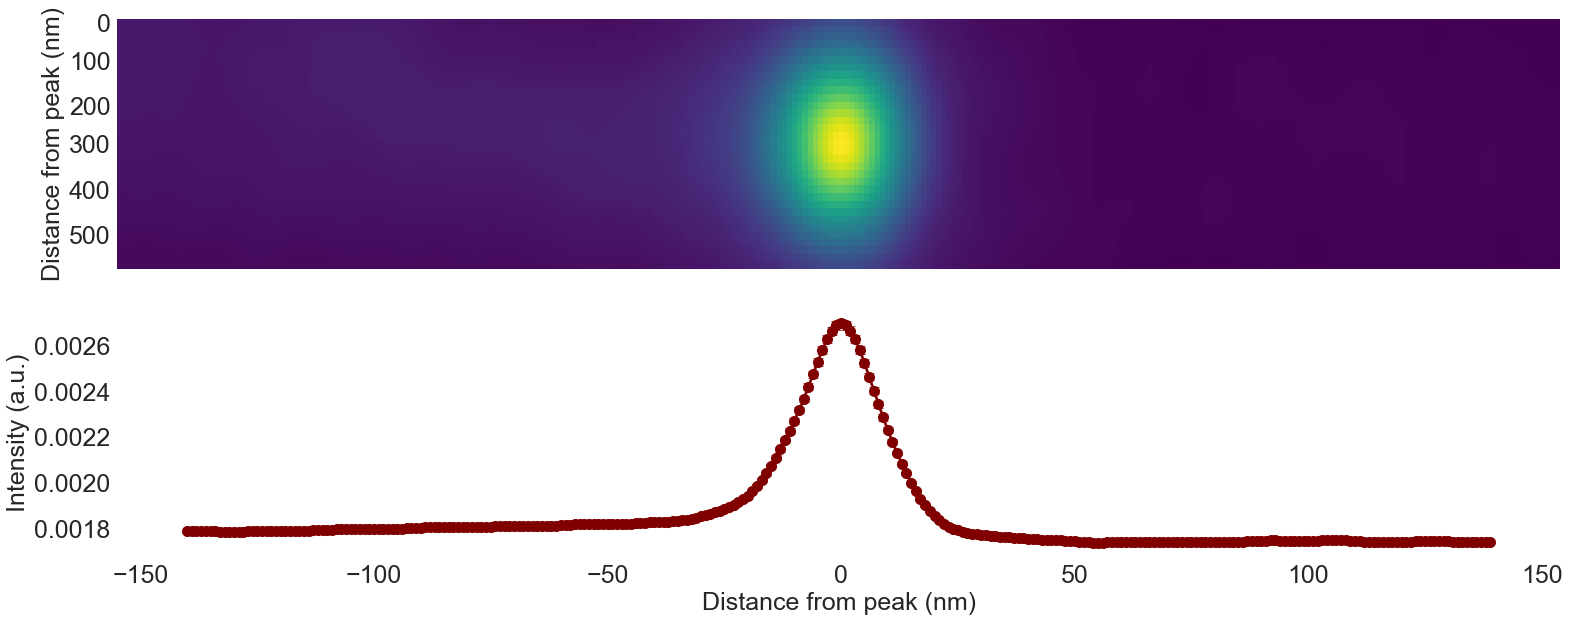

Done


In [4]:
################################################################################################################################
############# GET COMET PROFILES ###############################################################################################
################################################################################################################################

#Initialize lists
avgcomet_lst = []
profile_lst = []
profile_lst_norm = []
profilestd_lst = []
profilesem_lst = []
filtvelocities_lst = []
allvelocities_lst = []

###############################
##### ITERATE CONDITIONS ######
###############################

for condition_num in np.arange(0,len(conditions)):

    print("CONDITION: " + str(conditions[condition_num]))
    
    #Initialize lists
    allcomets = []
    filtvelocities = []
    allvelocities = []
    
    #Incrementor
    totalcomets = 0
    
    ###############################
    ##### ITERATE REPLICATES ######
    ###############################
    
    for replicate_num, replicate in enumerate(replicates[condition_num]):

        ##############################
        #### LOAD STACK ##############
        ##############################
        
        #################
        #Load file
        
        cometpath = os.path.join(paths[replicate], cometfiles[replicate])
        
        im = tifffile.imread(cometpath)

        #################
        #Store frames in list
        
        imstack = []

        for i in im:
            imstack.append(i)

        #################
        #Rescale if requested
            
        if rescale_flag == 1:

            imstack = np.array(imstack)
            imstack = (imstack - imstack.min())/(imstack.max() - imstack.min())

        #################
        #Get some properties of the stack
        
        num_slices = np.shape(im)[0]
        im_size = np.shape(im)[1]

        ##########################
        ##### GET ROIS ###########
        ##########################

        #################
        #Load roi file
        
        roipath = os.path.join(paths[replicate], roifiles[replicate])

        rois = read_roi_zip(roipath) #Hadrien's package

        #################
        #Store values in list
        
        roi_values = [ [k,v] for k, v in rois.items() ]

        comet_rois = []

        for i in np.arange(0, len(roi_values)-1, 2):

            comet_rois.append([(roi_values[i][1]['x'][0], roi_values[i][1]['y'][0]),
                               (roi_values[i+1][1]['x'][0], roi_values[i+1][1]['y'][0]),
                               (roi_values[i][1]['position'], roi_values[i+1][1]['position'])])

        ###############################
        ########  ANALYZE COMETS ######
        ###############################
        
        #Incrementor for comets outside of requested velocity range
        excluded = 0
        
        #Go throuch each comet
        for comet_num, (A, B, Z) in enumerate(comet_rois):           
            
            #Check how many comets there are here to print
            total_repcomets = len(comet_rois)

            print("Working on replicate #" + str(replicate_num+1) + ", comet #" + str(comet_num+1) + "/" + str(total_repcomets) + ", excluded " + str(excluded) + "       ", end='\r', flush=True)
            
            #################
            #Call process_comets function to get average aligned comet and profile
            
            aligned_comet_stack, peakpixels, velocity = process_comets(A, B, Z)

            #################
            #Store all velocities in allvelocities list
            
            allvelocities.append(velocity[0])

            #################
            #Store velocities that are within requested range in filtvelocities list
            
            if lower_range <= velocity <= upper_range:

                filtvelocities.append(velocity[0])

                for i in aligned_comet_stack:
                    allcomets.append(i)
      
            #################
            #Exclude comets that are outside of the the velocity range
            
            else:

                excluded += 1
                
            #Compile the number of comets there are in this dataset (including those that were excluded)
            totalcomets += total_repcomets

    #############################################
    ######  AVERAGE COMET AND PLOT PROFILE ######
    #############################################
    
    #################
    #Average all comets and get errors
    
    avg_aligned_comet = np.mean(allcomets, axis = 0)
    avg_aligned_comet_std = np.std(allcomets, axis = 0)
    avg_aligned_comet_sem = np.divide(avg_aligned_comet_std, np.sqrt(np.shape(allcomets)[0]))
    
    #################
    #Save average comet
    
    misc.imsave((os.path.join(savepath, str(conditions[condition_num]) + ' Average Comet.png')), avg_aligned_comet)
    
    #################
    #Plot profile is the profile along center of comet (i.e. y=imheight/2)
    
    centerpix = int(np.shape(avg_aligned_comet)[0]/2)
    
    #################
    #Extract profile and errors at center
    
    avg_aligned_comet_prof = avg_aligned_comet[centerpix,:]
    avg_aligned_comet_prof_std = avg_aligned_comet_std[centerpix,:]
    avg_aligned_comet_prof_sem = avg_aligned_comet_sem[centerpix,:]
    
    #################
    #Store normalized profile in new list
    avg_aligned_comet_prof_norm = (avg_aligned_comet_prof - np.amin(avg_aligned_comet_prof))/(np.amax(avg_aligned_comet_prof) - np.amin(avg_aligned_comet_prof))

    ###################
    ######  PLOT ######
    ###################
    
    #Define y-axis tick labels for image
    tickspacing_y = np.arange(0, avg_aligned_comet.shape[0], 100/to_nm).astype(int)
    ticklabels_y = np.arange(0, avg_aligned_comet.shape[0]*to_nm, 100).astype(int)

    fontsize = 25

    fig, ax = plt.subplots(2,1, figsize=(22, 9))
    
    ax = plt.subplot(2,1,1)
    plt.imshow(avg_aligned_comet, cmap="viridis", aspect='auto', interpolation='none')
    plt.yticks(tickspacing_y, ticklabels_y, fontsize = fontsize)
    plt.xticks([], [], fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.ylabel('Distance from peak (nm)', fontsize = fontsize)
    ax.set_facecolor('white')
    ax.grid(False)
    
    ax = plt.subplot(2,1,2)

    plt.plot(np.arange(-comet_length/2, comet_length/2), avg_aligned_comet_prof, linewidth = 2, color = 'Maroon')
    plt.scatter(np.arange(-comet_length/2, comet_length/2), avg_aligned_comet_prof, linewidth = 4, s = 50, color = 'Maroon')
    (_, caps, _) = plt.errorbar(np.arange(-comet_length/2, comet_length/2), avg_aligned_comet_prof, yerr = avg_aligned_comet_prof_sem, linewidth = 3,  color = 'Maroon', capsize= 5, alpha = 0.7)
        
    for cap in caps:
        cap.set_markeredgewidth(1)
        
    plt.xticks(fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.xlabel('Distance from peak (nm)', fontsize = fontsize)
    plt.ylabel('Intensity (a.u.)', fontsize = fontsize)
    ax.set_facecolor('white')
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()

    ########################################
    ###  ACCUMULATE FOR COMBINED PLOT ######
    ########################################
    
    avgcomet_lst.append(avg_aligned_comet)
    profile_lst_norm.append(avg_aligned_comet_prof_norm)
    profile_lst.append(avg_aligned_comet_prof)
    profilestd_lst.append(avg_aligned_comet_prof_std)
    profilesem_lst.append(avg_aligned_comet_prof_sem)
    filtvelocities_lst.append(filtvelocities)
    allvelocities_lst.append(allvelocities)
    
    ################################
    ### OUTPUT INFORMATION #########
    ################################
    
    # Output Profiles
    
    x = (np.arange(-comet_length/2, comet_length/2))*to_nm

    for p in np.arange(0, len(profile_lst_norm)):

        rows = zip(x, avg_aligned_comet_prof[::-1], avg_aligned_comet_prof_norm[::-1])

        with open(os.path.join(savepath, conditions[condition_num] + ' Raw and Normalized Profiles - mirrored.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            for row in rows:
                writer.writerow(row)
                
    # Output Report
    
    analyzedcomets = len(allcomets)

    velocity_output ='\nVelocity filtered: ' + str(lower_range) + ' to ' + str(upper_range) + ' um/min' + '\nAverage velocity = ' + str(np.around(np.mean(filtvelocities),1)) + ' +/- ' + str(np.around(np.std(filtvelocities),1)) + ' um/min' + '\nUnfiltered dataset has a mean of ' + str(np.around(np.mean(allvelocities),1)) + ' +/- ' + str(np.around(np.std(allvelocities),1))
    totalcomets_output = '\n\nTotal of ' + str(analyzedcomets) + ' comets analyzed out of ' + str(totalcomets) + '          \n'

    textoutput = velocity_output + totalcomets_output + '\n\nRescale flag = ' + str(rescale_flag) + '\nPixel size = ' + str(upix) + '\nSeconds per frame = ' + str(spf) + '\nSubsampling = ' + str(subfactor) + ' pixels' + '\n\nimheight = ' + str(imheight) + '\nspacex = ' + str(spacex) + '\ncomet_length = ' + str(comet_length) + '\ncomet_width = ' + str(comet_width) + '\nsearch_radius_x = ' + str(search_radius_x) + '\nsearch_radius_y = ' + str(search_radius_y)    
    text_file = open(savepath + str(conditions[condition_num]) + " Analysis Report.txt", "w")
    text_file.write(textoutput)
    text_file.close()
    
   
print("Done")

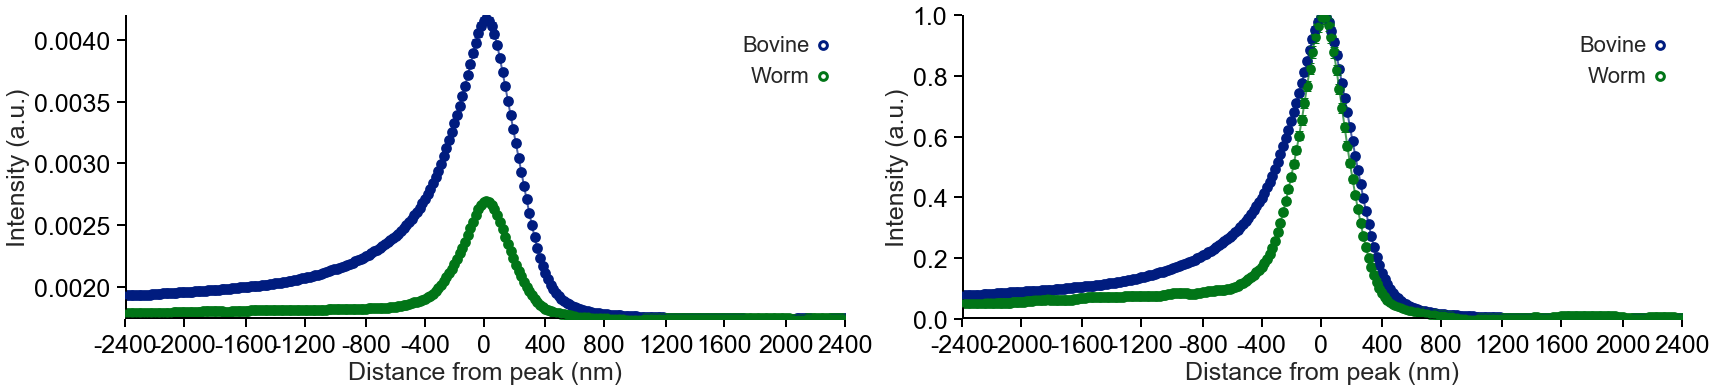

In [5]:

################################################################################################################################
######### OVERLAY THE CONDITIONS ###############################################################################################
################################################################################################################################
    
#####PLOT

fontsize = 25

legend = []

x_space = 400
relative2peak = int(avg_aligned_comet.shape[1]*to_nm/2)-x_space*int(int(avg_aligned_comet.shape[1]*to_nm/2)/x_space)
tickspacing_y = np.arange(0, avg_aligned_comet.shape[0], 100/to_nm).astype(int)
ticklabels_y = np.arange(0, avg_aligned_comet.shape[0]*to_nm, 100).astype(int)
tickspacing_x = np.arange(relative2peak/to_nm, avg_aligned_comet.shape[1], x_space/to_nm).astype(int)
ticklabels_x = np.arange(-x_space*int(int(avg_aligned_comet.shape[1]*to_nm/2)/x_space), x_space*int(int(avg_aligned_comet.shape[1]*to_nm/2)/x_space) + x_space, x_space).astype(int)

maxplot = 0
for condition in np.arange(0,len(conditions)):
    
    errplot_min = profile_lst[condition] - profilesem_lst[condition]
    errplot_max = profile_lst[condition] + profilesem_lst[condition]
    if np.amax(errplot_max) > maxplot:
        maxplot = np.amax(errplot_max)

fig, ax = plt.subplots(1,2, figsize=(24, 10))

###############################################

colors = sns.color_palette(sns.color_palette("Reds_d", n_colors=len(profile_lst)-1)) + sns.color_palette(sns.color_palette("Blues_d", n_colors=1))

colors = sns.color_palette('dark')

#colors = ['Firebrick', 'Dodgerblue']

###############################################
ax = plt.subplot(2,2,1)

minplot = np.amin(profile_lst)
    
for condition, color in zip(np.arange(0,len(conditions)), colors):
    
    plt.plot(np.arange(0, comet_length), profile_lst[condition], linewidth = 2, color = color, alpha = 0.7)
    plt.scatter(np.arange(0, comet_length), profile_lst[condition], linewidth = 3, s = 60, edgecolor = color, facecolor = 'White', alpha = 1, label = conditions[condition])
    (_, caps, _) = plt.errorbar(np.arange(0, comet_length), profile_lst[condition], yerr = profilesem_lst[condition], fmt='o', markersize=8, capsize=4, color = color)
    for cap in caps:
        cap.set_markeredgewidth(1)

plt.xticks(tickspacing_x, ticklabels_x, fontsize = fontsize)
plt.xlim(tickspacing_x[0], tickspacing_x[-1])
plt.yticks(fontsize = fontsize) #np.arange(0, 1.25, 0.25), 
plt.ylim(minplot, maxplot)
plt.xlabel('Distance from peak (nm)', fontsize = fontsize)
plt.ylabel('Intensity (a.u.)', fontsize = fontsize)
plt.legend(fontsize = fontsize-3, loc = 'upper right', handletextpad = 0.5, handlelength = 0.2, markerfirst = False)
plt.grid(False)
plt.axhline(y = minplot, color='k', linewidth = 4)
plt.axvline(x = tickspacing_x[0], color='k', linewidth = 4)
ax.tick_params(direction='out', length=8, width=2, colors='Black')
ax.set_facecolor('white')

###############################################
ax = plt.subplot(2,2,2)

for condition, color in zip(np.arange(0,len(conditions)), colors):

    prof_norm = (profile_lst[condition] - np.amin(profile_lst[condition]))/(np.amax(profile_lst[condition]) - np.amin(profile_lst[condition]))
    prof_sem = (profilesem_lst[condition])/(np.amax(profile_lst[condition]) - np.amin(profile_lst[condition]))
    
    plt.plot(np.arange(0, comet_length), prof_norm, linewidth = 2, color = color, alpha = 0.7)
    plt.scatter(np.arange(0, comet_length), prof_norm, linewidth = 3, s = 60, edgecolor = color, facecolor = 'White', alpha = 1, label = conditions[condition])
    (_, caps, _) = plt.errorbar(np.arange(0, comet_length), prof_norm, yerr = prof_sem, fmt='o', markersize=8, capsize=4, color = color)
    for cap in caps:
        cap.set_markeredgewidth(1)
        
plt.xticks(tickspacing_x, ticklabels_x, fontsize = fontsize)
plt.xlim(tickspacing_x[0], tickspacing_x[-1])
plt.yticks(fontsize = fontsize) #np.arange(0, 1.25, 0.25), 
plt.ylim(0, 1)
plt.xlabel('Distance from peak (nm)', fontsize = fontsize)
plt.ylabel('Intensity (a.u.)', fontsize = fontsize)
plt.legend(fontsize = fontsize-3, loc = 'upper right', handletextpad = 0.5, handlelength = 0.2, markerfirst = False)
plt.grid(False)
plt.axhline(y = 0, color='k', linewidth = 4)
plt.axvline(x = tickspacing_x[0], color='k', linewidth = 4)
ax.tick_params(direction='out', length=8, width=2, colors='Black')
ax.set_facecolor('white')

plt.tight_layout()
#fig.savefig(os.path.join(savepath, "Averaged comet plot.pdf"))



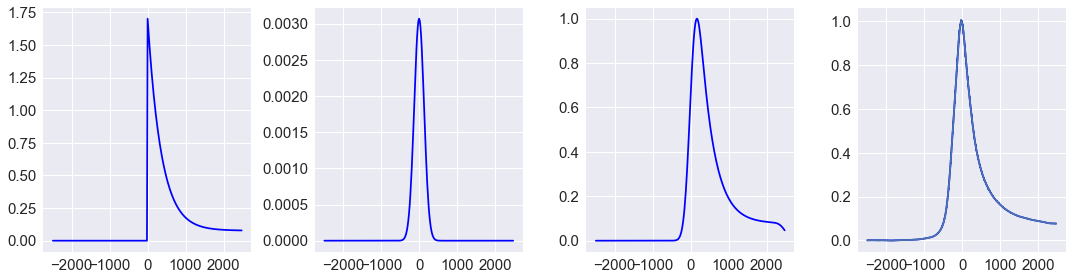

nlat = 0.07712560122227065
         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 km  :  -0.02119  -0.01439  -0.00735   0.24286  +0.00772  +0.01591  +0.02465
 nlat:  -0.01012  -0.00666  -0.00329   0.09962  +0.00325  +0.00649  +0.00974
 xc  : -16.16385 -11.02823  -5.67486-227.60990  +5.34526 +10.92302 +16.77238
86.06285531364284 4.338139986716355

THE COMET LENGTH IS: 339.3916743746106 +/- 21.886435741233704


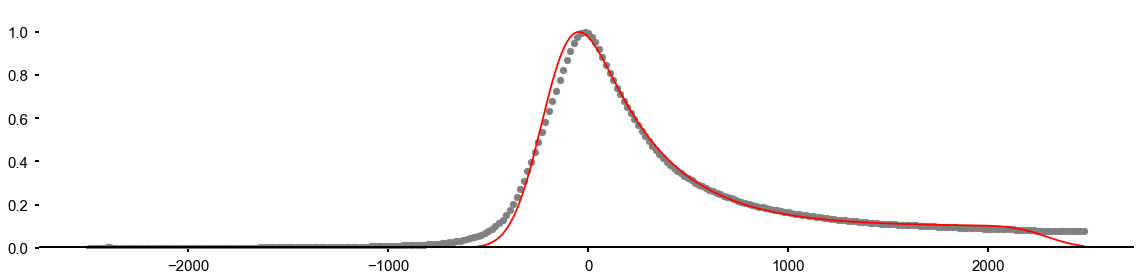

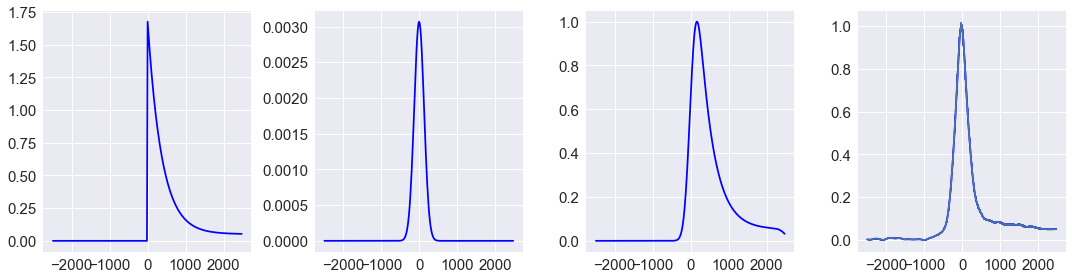

nlat = 0.051348976584016666
         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 km  :  -0.04403  -0.02998  -0.01535   0.58418  +0.01623  +0.03353  +0.05209
 nlat:  -0.00383  -0.00255  -0.00127   0.04368  +0.00128  +0.00258  +0.00390
 xc  :  -9.55457  -6.48842  -3.16065-156.00349  +2.96122  +5.99549  +9.13160
88.93506033994997 4.483528041610515

THE COMET LENGTH IS: 143.99282634793488 +/- 20.162273479379607


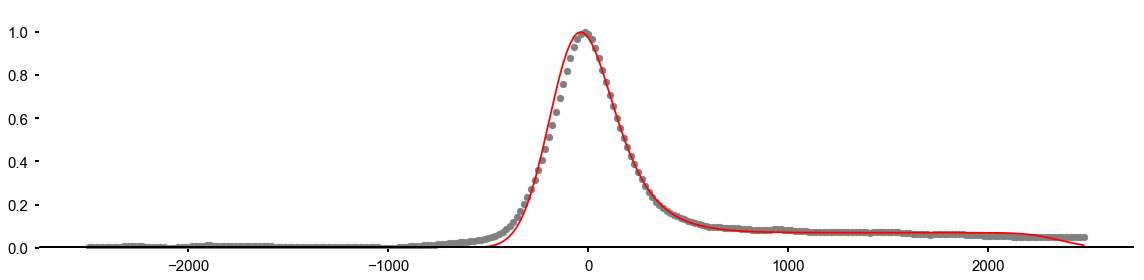

In [146]:
from scipy.stats import norm

################################################################################################################################
############# FIT PLOT PROFILES ################################################################################################
################################################################################################################################

###########################

def normalized_data(data, data_err):
    normdata = (data-np.min(data))/(np.amax(data)-np.amin(data))
    normerr = (data_err)/(np.amax(data)-np.amin(data))
    return(normdata, normerr)

def normalize(x):
    return((x-np.amin(x))/(np.amax(x)-np.amin(x)))

####################################

def binding_sites(x, pf, km, vg, d, nlat):
    
    return(np.heaviside((x-d), 1)*(((pf/8)*np.exp(-(x-d)*km/vg) + nlat)))


def gaussian(x, sigma, xc):
    
    #sigma = 1.25*sigma
    
    return(norm.pdf(x, loc=xc, scale=sigma))
    #return((1/(sigma*np.sqrt(2*3.14)))*np.exp((-1/2)*((x-xc)/sigma)**2))
    #return(np.exp((-1/2)*((x-xc)/sigma)**2))

def convolved_profile(x, pf, km, vg, d, nlat, sigma, xc):
    
    profile = binding_sites(x, pf, km, vg, d, nlat)
    
    psf = gaussian(x, sigma, xc)
    
    return(normalize(np.convolve(profile, psf, mode='same')))


##################################

fitparams_lst = []

for p,e,v in zip(profile_lst, profilesem_lst, filtvelocities_lst):

    x_data = (np.arange(-comet_length/2, comet_length/2))*to_nm

    data = p[::-1]
    data_err = e[::-1]
    data_weights = [1/i for i in data_err]
    vg = np.mean(v)*1000/60
    vg_err = np.std(v)*1000/60

    data, data_err = normalized_data(data, data_err)
    
    fig, ax = plt.subplots(1,4, figsize=(15, 4))
    
    ax = plt.subplot(1,4,1)
    plt.plot(x_data, binding_sites(x_data, 13, km0, vg, 0, data[-1]), color = 'blue')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
    ax = plt.subplot(1,4,2)
    plt.plot(x_data, gaussian(x_data, sigma, 0), color = 'blue')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
    ax = plt.subplot(1,4,3)
    plt.plot(x_data, convolved_profile(x_data, 13, km0, vg, 0, data[-1], sigma, 0), color = 'blue')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)

    ax = plt.subplot(1,4,4)
    plt.plot(x_data, data, color = 'blue')
    plt.errorbar(x_data, data, yerr = data_err)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.tight_layout()
    plt.show()
    
    print("nlat = " + str(data[-1]))

    ############################

    gmodel = Model(convolved_profile)

    result = gmodel.fit(data, x=x_data, weights=data_weights,
                        pf=Parameter('pf', value=13, vary=False, min=10, max=15),
                        km=Parameter('km', value=km0, vary=True, min=0.01, max=3),
                        vg=Parameter('vg', value=vg, vary=False),
                        d=Parameter('d', value=0, vary=False),
                        nlat=Parameter('nlat', value=data[-1], vary=True, min=data[-1]-0.05, max=data[-1]+0.05),
                        sigma=Parameter('sigma', value=sigma, vary=False, min=sigma),
                        xc=Parameter('xc', value=0, vary=True, min=-500, max=100))

    #print(result.fit_report())
    print(result.ci_report())
    
    fpf = result.values['pf']
    fkm = result.values['km']
    fvg = result.values['vg']
    fd = result.values['d']
    fnlat = result.values['nlat']
    fsigma = result.values['sigma']
    fxc = result.values['xc']
    
    km_lower = fkm - result.conf_interval()['km'][1][1]
    km_upper = result.conf_interval()['km'][5][1] - fkm
    kmci = (km_lower + km_upper)/2 #95% interval
    
    print(vg, vg_err)
    result_comet_length = fvg/fkm
    result_comet_length_err = comet_length*np.sqrt((vg_err/vg)**2 + (kmci/fkm)**2)
    
    print("\nTHE COMET LENGTH IS: " + str(result_comet_length) + " +/- " + str(result_comet_length_err))
    
    fitparams = [fpf, fkm, fvg, fd, fnlat, fsigma, fxc]
    fitparams_lst.append(fitparams)

    ####################################
    
    convolved_fit = convolved_profile(x_data, fpf, fkm, fvg, fd, fnlat, fsigma, fxc)
    
    shift = 0#int(np.where(convolved_fit == np.amax(convolved_fit))[0]-comet_length/2+1)

    fig, ax = plt.subplots(1,1, figsize=(16, 4))

    ax = plt.subplot(1,1,1)

    plt.scatter(x_data, data, color = 'gray')
    plt.plot(x_data[0:(np.shape(x_data)[0]-shift)], convolved_fit[shift:], color = 'red')
    plt.ylim(0,1.1)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.grid(False)
    ax.set_facecolor('white')
    plt.axhline(y = 0, color='k', linewidth=4)
    #plt.axvline(x = 0, color='k', linewidth=2)
    ax.tick_params(direction='out', length=4, width=2, colors='Black')

    plt.tight_layout()
    plt.show()

    ##################

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


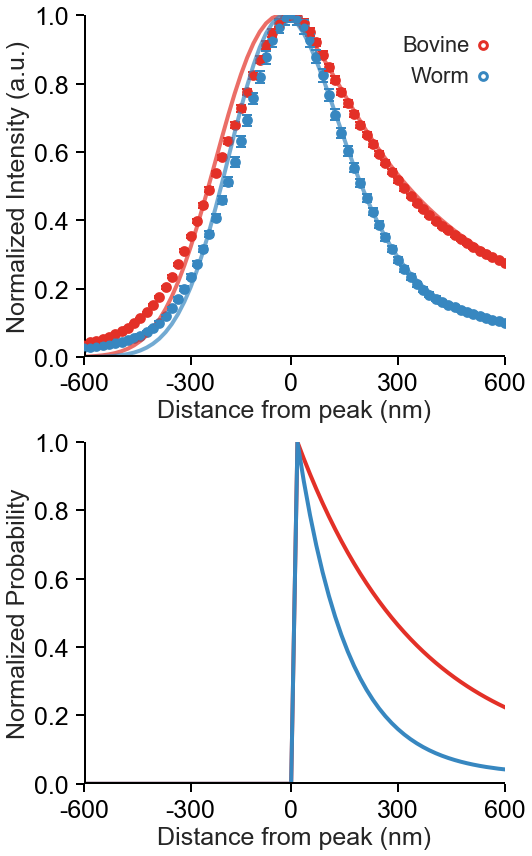

In [147]:
################################################################################################################################
############# OVERLAY FIT PLOT PROFILES ########################################################################################
################################################################################################################################

x_space = 300
relative2peak = int(avg_aligned_comet.shape[1]*to_nm/2)-x_space*int(int(avg_aligned_comet.shape[1]*to_nm/2)/x_space)
tickspacing_y = np.arange(0, avg_aligned_comet.shape[0], 100/to_nm).astype(int)
ticklabels_y = np.arange(0, avg_aligned_comet.shape[0]*to_nm, 100).astype(int)
tickspacing_x = np.arange(relative2peak/to_nm, avg_aligned_comet.shape[1], x_space/to_nm).astype(int)
ticklabels_x = np.arange(-x_space*int(int(avg_aligned_comet.shape[1]*to_nm/2)/x_space), x_space*int(int(avg_aligned_comet.shape[1]*to_nm/2)/x_space) + x_space, x_space).astype(int)

x_data = (np.arange(-comet_length/2, comet_length/2))*to_nm

fig, ax = plt.subplots(2,1, figsize=(7.5, 12))
colors = sns.color_palette(sns.color_palette("Reds_d", n_colors=1)) + sns.color_palette(sns.color_palette("Blues_d", n_colors=1))

ax = plt.subplot(2,1,1)

for condition, color in zip(np.arange(0,len(conditions)), colors):

    prof_norm = (profile_lst[condition] - np.amin(profile_lst[condition]))/(np.amax(profile_lst[condition]) - np.amin(profile_lst[condition]))
    prof_sem = (profilesem_lst[condition])/(np.amax(profile_lst[condition]) - np.amin(profile_lst[condition]))
    
    plt.plot(np.arange(0, comet_length), convolved_profile(x_data, *fitparams_lst[condition]), linewidth = 4, color = color, alpha = 0.7)
    plt.scatter(np.arange(0, comet_length), prof_norm[::-1], linewidth = 3, s = 60, edgecolor = color, facecolor = 'White', alpha = 1, label = conditions[condition])
    (_, caps, _) = plt.errorbar(np.arange(0, comet_length), prof_norm[::-1], yerr = prof_sem[::-1], fmt='o', markersize=8, capsize=5, color = color)
    for cap in caps:
        cap.set_markeredgewidth(2)
        
plt.xticks(tickspacing_x, ticklabels_x, fontsize = fontsize)
plt.xlim(tickspacing_x[int(len(tickspacing_x)/2-2)], tickspacing_x[int(len(tickspacing_x)/2+2)])
plt.yticks(fontsize = fontsize) #np.arange(0, 1.25, 0.25), 
plt.ylim(0, 1)
plt.xlabel('Distance from peak (nm)', fontsize = fontsize)
plt.ylabel('Normalized Intensity (a.u.)', fontsize = fontsize)
plt.legend(fontsize = fontsize-3, loc = 'upper right', handletextpad = 0.5, handlelength = 0.2, markerfirst = False)
plt.grid(False)
plt.axhline(y = 0, color='k', linewidth = 4)
plt.axvline(x = tickspacing_x[int(len(tickspacing_x)/2-2)], color='k', linewidth = 4)
ax.tick_params(direction='out', length=8, width=2, colors='Black')
ax.set_facecolor('white')

ax = plt.subplot(2,1,2)

for condition, color in zip(np.arange(0,len(conditions)), colors):
    
    plt.plot(np.arange(0, comet_length), normalize(binding_sites(x_data, *fitparams_lst[condition][:-2])), linewidth = 4, color = color, alpha = 1)
        
plt.xticks(tickspacing_x, ticklabels_x, fontsize = fontsize)
plt.xlim(tickspacing_x[int(len(tickspacing_x)/2-2)], tickspacing_x[int(len(tickspacing_x)/2+2)])
plt.yticks(fontsize = fontsize) #np.arange(0, 1.25, 0.25), 
plt.ylim(0, 1)
plt.xlabel('Distance from peak (nm)', fontsize = fontsize)
plt.ylabel('Normalized Probability', fontsize = fontsize)
plt.legend(fontsize = fontsize-3, loc = 'upper right', handletextpad = 0.5, handlelength = 0.2, markerfirst = False)
plt.grid(False)
plt.axhline(y = 0, color='k', linewidth = 4)
plt.axvline(x = tickspacing_x[int(len(tickspacing_x)/2-2)], color='k', linewidth = 4)
ax.tick_params(direction='out', length=8, width=2, colors='Black')
ax.set_facecolor('white')

plt.tight_layout()
#fig.savefig(os.path.join(savepath, "Normalized plots with fitted curves.pdf"))